In [1]:
import os
import random
import time
import numpy as np
import sys
import torch
import torch.nn as nn
from nn.encoder import MobileNetV2
from nn.decoder import Decoder
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import shutil
from thop import profile
from thop import clever_format
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
IMG_SCALE = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
SEGMENTER_CKPT_PATH = \
    {
        'celebA':'./ckpt/_train_celebA/segmenter_checkpoint_0.11.pth.tar',
        'EG1800': './ckpt/_train_EG1800/segmenter_checkpoint.pth.tar',
        'helen': './ckpt/_train_helen/segmenter_checkpoint_0.16.pth.tar', 
    }

decoder_config = \
    {
        'celebA':  [[3, [1, 1, 5, 0], [0, 4, 1, 9], [4, 3, 2, 0]], [[3, 3], [2, 1], [2, 0], [1,4]]] , 
        'EG1800':[[1, [0, 0, 10, 9], [0, 1, 2, 7], [2, 0, 0, 9]], [[2, 0], [3, 2], [2, 4]]],
        'helen':[[5, [1, 0, 3, 5], [1, 0, 10, 10], [6, 6, 0, 10]], [[1, 0], [4, 2], [3, 2],[0,2],[1,4]]], 
    }

NUM_CLASSES = {'celebA':19,'EG1800':2,'helen':11}
### see the color config in dmh code
color_list = [[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], [255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0]]


In [4]:
class Segmenter(nn.Module):
    def __init__(self, encoder, decoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [5]:
def create_seger(dataset_type,config):
    encoder = MobileNetV2()
    decoder = Decoder(inp_sizes=encoder.out_sizes,
                      num_classes=NUM_CLASSES[dataset_type],
                      config=config,
                      fused_feature_size=48,
                      )

    segmenter = nn.DataParallel(Segmenter(encoder, decoder)).cuda()
    del encoder

    segmenter.load_state_dict(torch.load(SEGMENTER_CKPT_PATH[dataset_type]), strict=False)
    segmenter.eval()
    return segmenter

# EG1800

### MobileNet-v2 + Searched decoder (genotype: [[1, [0, 0, 10, 9], [0, 1, 2, 7], [2, 0, 0, 9]], [[2, 0], [3, 2], [2, 4]]])

In [6]:
imgs_eg1800 = [
    './data/EG1800/Images/02323.png', # EG1800
    './data/EG1800/Images/01232.png',
    './data/EG1800/Images/02178.png',
    './data/EG1800/Images/02033.png',
    './data/EG1800/Images/02235.png',
    './data/EG1800/Images/00105.png',
]
msks_eg1800 = [
    './data/EG1800/Labels/02323.png',  # EG1800
    './data/EG1800/Labels/01232.png',
    './data/EG1800/Labels/02178.png',
    './data/EG1800/Labels/02033.png',
    './data/EG1800/Labels/02235.png',
    './data/EG1800/Labels/00105.png',
]

/home/lvbo1/anaconda3/envs/py3_6_nas_seg/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/lvbo1/anaconda3/envs/py3_6_nas_seg/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


546.867M
2.029M
Testing image:./data/EG1800/Images/02323.png
Testing image:./data/EG1800/Images/01232.png
Testing image:./data/EG1800/Images/02178.png
Testing image:./data/EG1800/Images/02033.png
Testing image:./data/EG1800/Images/02235.png
Testing image:./data/EG1800/Images/00105.png


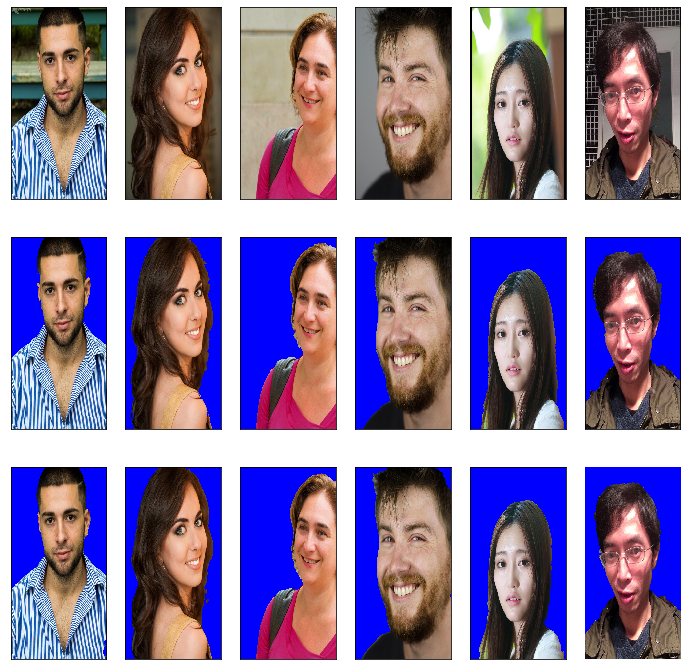

In [7]:
TEST_NUM =  6
fig, axes = plt.subplots(3, TEST_NUM, figsize=(12, 12))
# axes.set_xticks
ax= axes.ravel()
color_array = np.array(color_list)
random.seed()
dataset_type='EG1800'
segmenter = create_seger(dataset_type, decoder_config[dataset_type])
input = torch.randn(1,3,224,224)
flops, params = profile(segmenter, inputs = (input,), )
flops, params = clever_format([flops, params], "%.3f")
print(flops)
print(params)
for i,img_path in enumerate(imgs_eg1800):
    print("Testing image:{}".format(img_path))
    img = np.array(Image.open(img_path))
    msk = np.array(Image.open(msks_eg1800[i]))
    orig_size = img.shape[:2][::-1]
    ax[i].imshow(img,aspect='auto')
    plt.axis('off')
    img_msk = img.copy()
    img_msk[msk == 0] = (0,0,255)
    ax[TEST_NUM+i].imshow(img_msk,aspect='auto')
    plt.axis('off')

    img_inp = torch.tensor(prepare_img(img).transpose(2, 0, 1)[None]).float().to(device)
    segm = segmenter(img_inp)[0].squeeze().data.cpu().numpy().transpose((1, 2, 0)) #47*63*21
    #cal params and flops

    segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC) #375*500*21  #EG1800 need
    segm = segm.argmax(axis=2).astype(np.uint8)
    img_segm = img.copy()
    img_segm[segm == 0] = (0,0,255)
    ax[2*TEST_NUM+i].imshow(img_segm,aspect='auto')

    plt.axis('off')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()


# HELEN

### MobileNet-v2 + Searched decoder (genotype:[[5, [1, 0, 3, 5], [1, 0, 10, 10], [6, 6, 0, 10]], [[1, 0], [4, 2], [3, 2],[0,2],[1,4]]])

In [8]:
imgs_helen = [
    './data/helen/141794264_1_image.jpg',   #HELEN
    './data/helen/107635070_1_image.jpg',
    './data/helen/1030333538_1_image.jpg',
    './data/helen/122276700_1_image.jpg',
    './data/helen/1344304961_1_image.jpg',
    './data/helen/1240746154_1_image.jpg',
]
msks_helen = [
    './data/helen/141794264_1_label.png',  # HELEN
    './data/helen/107635070_1_label.png',
    './data/helen/1030333538_1_label.png',
    './data/helen/122276700_1_label.png',
    './data/helen/1344304961_1_label.png',
    './data/helen/1240746154_1_label.png'
]

5.725G
2.351M
Testing image:./data/helen/141794264_1_image.jpg
Testing image:./data/helen/107635070_1_image.jpg
Testing image:./data/helen/1030333538_1_image.jpg
Testing image:./data/helen/122276700_1_image.jpg
Testing image:./data/helen/1344304961_1_image.jpg
Testing image:./data/helen/1240746154_1_image.jpg


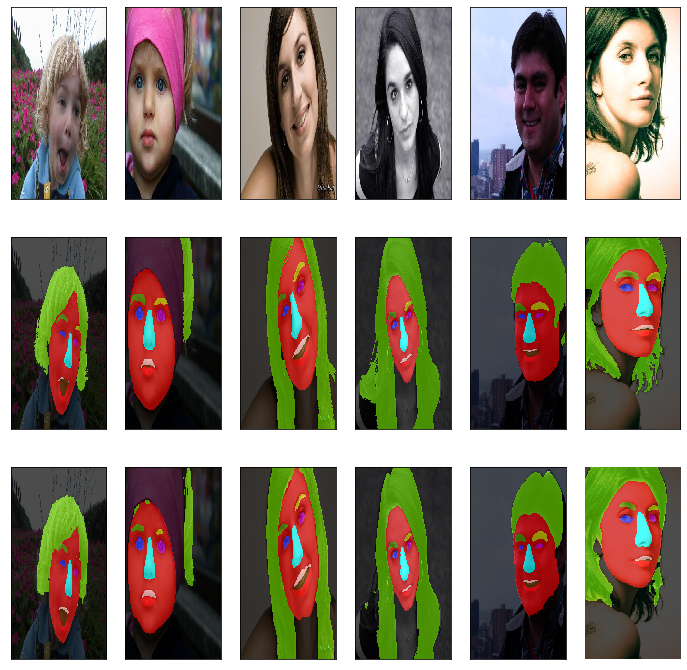

In [9]:
fig, axes = plt.subplots(3, TEST_NUM, figsize=(12, 12))
# axes.set_xticks
ax= axes.ravel()
dataset_type='helen'
segmenter = create_seger(dataset_type, decoder_config[dataset_type])
input = torch.randn(1,3,512,512)
flops, params = profile(segmenter, inputs = (input,), )
flops, params = clever_format([flops, params], "%.3f")
print(flops)
print(params)
for i,img_path in enumerate(imgs_helen):
    print("Testing image:{}".format(img_path))
    img = np.array(Image.open(img_path))
    msk = np.array(Image.open(msks_helen[i]))
    orig_size = img.shape[:2][::-1]
    ax[i].imshow(img,aspect='auto')
    plt.axis('off')

    ax[TEST_NUM+i].imshow(img,aspect='auto')
    msk = color_array[msk]
    ax[TEST_NUM+i].imshow(msk,aspect='auto',alpha=0.7)

    plt.axis('off')

    img_inp = torch.tensor(prepare_img(img).transpose(2, 0, 1)[None]).float().to(device)
    segm = segmenter(img_inp)[0].squeeze().data.cpu().numpy().transpose((1, 2, 0))

    segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC) 
    segm = segm.argmax(axis=2).astype(np.uint8)

    segm = color_array[segm]
    ax[2*TEST_NUM+i].imshow(img,aspect='auto')
    ax[2*TEST_NUM+i].imshow(segm,aspect='auto',alpha=0.7)
    plt.axis('off')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

# CelebA-mask

### MobileNet-v2 + Searched decoder (genotype: [[3, [1, 1, 5, 0], [0, 4, 1, 9], [4, 3, 2, 0]], [[3, 3], [2, 1], [2, 0], [1,4]]])

In [10]:
imgs_celebA = [
    './data/celebA/29044.jpg',
    './data/celebA/27039.jpg',
    './data/celebA/27047.jpg',
    './data/celebA/27037.jpg', 
    './data/celebA/29045.jpg',
    './data/celebA/29022.jpg', 
]
msks_celebA = [

    './data/celebA/29044.png',
    './data/celebA/27039.png',
    './data/celebA/27047.png',
    './data/celebA/27037.png',
    './data/celebA/29045.png',
    './data/celebA/29022.png',
]

3.400G
2.293M
Testing image:./data/celebA/29044.jpg
Testing image:./data/celebA/27039.jpg
Testing image:./data/celebA/27047.jpg
Testing image:./data/celebA/27037.jpg
Testing image:./data/celebA/29045.jpg
Testing image:./data/celebA/29022.jpg


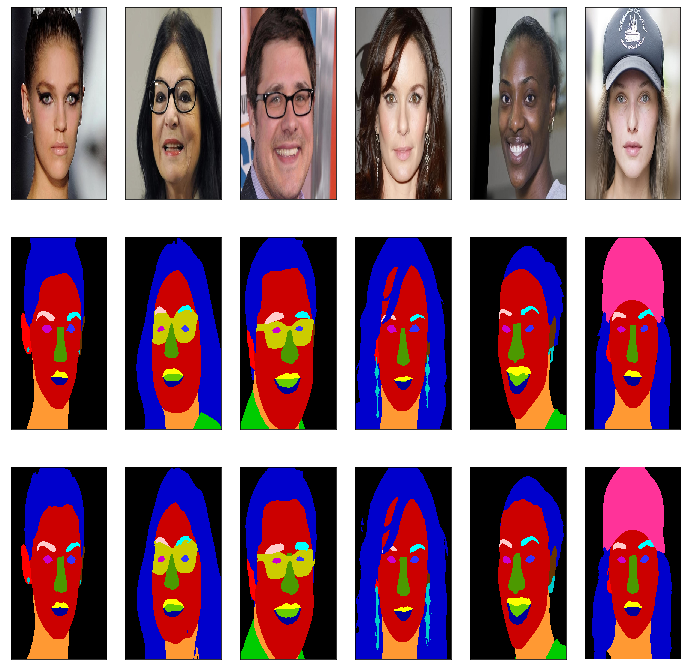

In [11]:
TEST_NUM=6
fig, axes = plt.subplots(3, TEST_NUM, figsize=(12, 12))
# axes.set_xticks
ax= axes.ravel()
dataset_type='celebA'
segmenter = create_seger(dataset_type, decoder_config[dataset_type])
input = torch.randn(1,3,512,512)
# flops, params = profile(segmenter, inputs = (img_inp,), )
flops, params = profile(segmenter, inputs = (input,), )
flops, params = clever_format([flops, params], "%.3f")
print(flops)
print(params)
for i,img_path in enumerate(imgs_celebA):
    print("Testing image:{}".format(img_path))
    img = np.array(Image.open(img_path))
    msk = np.array(Image.open(msks_celebA[i]))
    orig_size = img.shape[:2][::-1]
    ax[i].imshow(img,aspect='auto')
    plt.axis('off')

    msk = color_array[msk]
    ax[TEST_NUM+i].imshow(msk,aspect='auto',)

    plt.axis('off')

    img_inp = torch.tensor(prepare_img(img).transpose(2, 0, 1)[None]).float().to(device)
    segm = segmenter(img_inp)[0].squeeze().data.cpu().numpy().transpose((1, 2, 0)) 


    segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
    segm = segm.argmax(axis=2).astype(np.uint8)
    segm = color_array[segm]  

    ax[2*TEST_NUM+i].imshow(segm, aspect='auto',)
    ax[2*TEST_NUM+i].set_xticks([])
    ax[2*TEST_NUM+i].set_yticks([])
    plt.axis('off')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()